In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from data_swerick import create_dataset_swerick
from evaluation import evaluation_task
import preprocessing
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [6]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12319
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2683
    })
})


In [7]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets

Map:   0%|          | 0/12319 [00:00<?, ? examples/s]

In [ ]:
chunk_size = 128

In [11]:
with open("token_dataset.pkl","wb") as f:
    pickle.dump(tokenized_datasets,f)

In [18]:
tokenized_datasets=tokenized_datasets.remove_columns("protocole")


ValueError: Column name ['protocole'] not in the dataset. Current columns in the dataset: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids']

In [ ]:
tokenized_datasets["train"]

In [6]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

NameError: name 'tokenized_datasets' is not defined

In [29]:
with open("lm_dataset.pkl","wb") as f:
    pickle.dump(lm_datasets,f)

In [6]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [8]:
data_valid={"valid":"swerick_data_random_valid.pkl"}
valid_dataset = load_dataset("pandas",data_files=data_valid) 
valid_dataset =preprocessing.tokenize_dataset(valid_dataset,tokenizer)
valid_dataset=preprocessing.grouping_dataset(valid_dataset,chunk_size)

valid_dataset

In [10]:
with open("valid_dataset.pkl","wb") as f:
     pickle.dump(valid_dataset,f)

In [7]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 800106
    })
})

In [8]:

valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])

In [9]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

trial with a manual implementation

In [16]:
print(lm_datasets["train"])

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)

print(eval_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 3663965
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


KeyError: "Column valid not in the dataset. Current columns in the dataset: ['input_ids', 'attention_mask', 'labels']"

In [11]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to("cpu") for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)
print("ok")

#for batch in train_dataloader:
    #batch = to_device(batch)

#for batch in eval_dataloader:
    #batch = to_device(batch)




print(eval_dataloader.dataset)

ok
ok
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [13]:
print(train_dataloader.dataset)
print(eval_dataloader)

for batch in eval_dataloader:
    print(batch["input_ids"].device)
    break

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3663965
})
cpu


In [15]:
print(len(train_dataloader))

893


In [16]:
def get_dataloader():
    train =DataLoader(
    lm_dataset_bis["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator)
    train = [inputs.to(device) for inputs in train_dataloader]
    return train


for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break

for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break



##försvar, industriellberedskap, ekonomiskberedskapo. s. v. Manharräknatmedolikakostnaderfördessaochsedanförsöktfog [MASK]hopdessabyggklotsartillenen [MASK] 90Nr10Onsdagenden23 [MASK]s1955Överbefälhavarensutredningrörandekrigsmaktensutvecklinghetligbyggnad. [UNK]. HerrHjalmarsonvari rest [MASK]åenfråga [MASK] somjagmednåg [MASK]ynpunktervillspinnavidarep [MASK]. Vilkenärsj [MASK]agrundenförÖB - utredningens [MASK] [MASK]? [MASK], minadamerochherrar, det [MASK], attdetta [MASK]representerardetminimumsom
##inläggetskullekanskeintebehövanågotgenmäle, tyjagkonstaterarmedtillfreds [MASK], attherr [MASK]rhén [MASK]kommitmerapappersliknandevåglängdsomjagäridennas [MASK], [MASK]jagnufåruttryckamigså. Jagvilldockgöraetttillugerläggande. Manharpåvissthåll [MASK]tförlöjligavadsomskeddeiuniversitetsutredningengenomatts [MASK]attordföranden, d. v [MASK] [MASK]. statssekreterare [MASK]denman, skrevtillsigsjälv. Det [MASK]håller [MASK] [MASK]allspådets [MASK]t, utanvidenavdeförsta [MASK]gångarnaunder

In [17]:
model_bis = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_bis=model_bis.to("cpu")

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_bis.eval()

total_loss = 0.0  # Variable to accumulate total loss

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model_bis(**batch)
    loss = outputs.loss
    total_loss += loss.item()   # Accumulate the batch loss

# Calculate the average loss
average_loss = total_loss / len(eval_dataloader)

print(f"Initial Loss: {average_loss}")

In [ ]:

optimizer = AdamW(model_bis.parameters(), lr=1.3e-5)
print(optimizer)

In [ ]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

losses_train=[]
losses_test=[]
#train_dataloader = get_dataloader()
for epoch in range(num_train_epochs):
    # Training
    model_bis.train()
    print(next(model_bis.parameters()).device)
    print(epoch)
    params_before_optimization = [param.data.clone() for param in model_bis.parameters()]
    total_loss_train = 0.0 
    train_dataloader = get_dataloader()

    for batch in train_dataloader:
        outputs = model_bis(**batch)
        loss = outputs.loss
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        params_after_optimization = [param.data for param in model_bis.parameters()]
        parameters_changed = any((param_before != param_after).any() for param_before, param_after in zip(params_before_optimization, params_after_optimization))
        #if parameters_changed==True :
             # print(parameters_changed) 
        progress_bar.update(1)

    losses_train.append(total_loss_train/len(train_dataloader))
    print("losses_train",losses_train)

    # Evaluation
    model_bis.eval()
    losses=[]
    total_loss_eval=0.0
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model_bis(**batch)

        loss = outputs.loss
        losses.append(loss.repeat(batch_size))
        total_loss_eval +=loss.item()


    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
       perplexity = float("inf")

    losses_test.append(total_loss_eval/len(eval_dataloader))


    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    print("losses_test",losses_test)

print("epoch",num_train_epochs)
plt.plot(range(num_train_epochs),losses_train,label="train Loss")

plt.plot(range(num_train_epochs),losses_test,label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

            

In [ ]:
print(losses_train)
print(losses_test)

In [ ]:
file_path = "finetuning_manual"
model_bis.save_pretrained(file_path)
tokenizer.save_pretrained(file_path)

In [ ]:
import pickle

file_name = "losses.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': losses_train, 'losses_test': losses_test}, f)


In [ ]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model="./test_model")

In [15]:
model_long=AutoModelForMaskedLM.from_pretrained("./finetuning_hugging-finetuned-imdb/checkpoint-259384")
model_long=model_long.to("cpu")

In [17]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to("cpu")

In [12]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace-finetuned-imdb/checkpoint-572500")
model_hugging_face=model_hugging_face.to(device)

In [18]:
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
evaluation_task(model_hugging_face,valid_dataloader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-572500")

Trainer evaluation....
Accuracy...
Party classification
training
stdout: ['"vänstern"', 'Andra kammarens center', 'Andra kammarens frihandelsparti', 'Bondeförbundet', 'Centern (partigrupp 1873-1882)', 'Centern (partigrupp 1885-1887)', 'Centerpartiet', 'Det förenade högerpartiet', 'Ehrenheimska partiet', 'Folkpartiet', 'Folkpartiet (1895–1900)', 'Friesenska diskussionsklubben', 'Frihandelsvänliga centern', 'Frisinnade folkpartiet', 'Frisinnade försvarsvänner', 'Frisinnade landsföreningen', 'Första kammarens konservativa grupp', 'Första kammarens ministeriella grupp', 'Första kammarens minoritetsparti', 'Första kammarens moderata parti', 'Första kammarens nationella parti', 'Första kammarens protektionistiska parti', 'Gamla lantmannapartiet', 'Högerns riksdagsgrupp', 'Högerpartiet', 'Högerpartiet de konservativa', 'Jordbrukarnas fria grupp', 'Junkerpartiet', 'Kilbomspartiet', 'Kommunistiska partiet', 'Kristdemokraterna', 'Lantmanna- och borgarepartiet inom andrakammaren', 'Lantmannaparti

In [17]:
evaluation_task(model,valid_dataloader)

Trainer evaluation....


  0%|          | 0/12502 [00:00<?, ?it/s]

{'eval_loss': 2.2889373302459717, 'eval_runtime': 1670.4142, 'eval_samples_per_second': 478.987, 'eval_steps_per_second': 7.484}
>>> Perplexity: 9.86
Manual perplexity...
 Perplexity: 9.864508254198425
Accuracy...
Accuracy: 0.588802334176737


In [28]:
for batch in eval_dataloader:
    print(batch)
    break

{'input_ids': tensor([[    4,     4, 49795,  ..., 49795,  6742,     4],
        [10996,   688, 12494,  ...,  3193, 13781,    19],
        [18059,   183,  2261,  ...,    24, 48380, 48465],
        ...,
        [49816, 21033,    49,  ...,   469,  1314, 49830],
        [21264,  1219,     4,  ..., 11583,   546, 20805],
        [    7,     1,     4,  ...,     4,     4, 28662]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[  109, 28534,  -100,  ...,  -100,  -100, 15873],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        ...,
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100, 38839,  ...,  -100,  -100,  -100],
        [ -100,  -100,     7,  ...,    37,  2193,  -100]])}


In [16]:
math.exp(0.13192342221736908)

1.1410209390681376

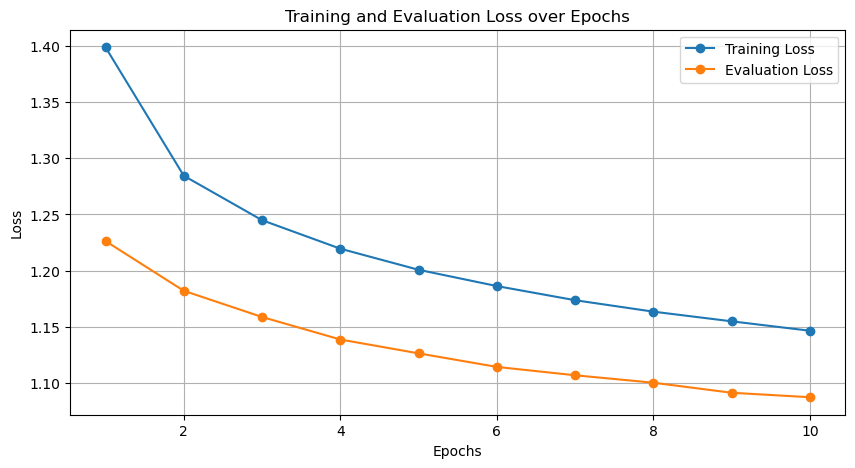

In [15]:
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open("finetuning_hugging_whitespace-finetuned-imdb/checkpoint-572500/trainer_state.json", 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
pad_token_id= tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

In [55]:
import numpy as np

In [63]:
max_length=128

In [107]:
def insert_special_masking(batch,i):
    word_ids=batch["word_ids"]
 
    masked_input_id=batch["input_ids"].copy()
    attention_mask=batch["attention_mask"].copy()
 
    labels=[[-100]*max_length]*len(batch["labels"])
    for z in range(len(masked_input_id)):
        if batch["input_ids"][z][i] ==tokenizer.pad_token_id or batch["input_ids"][z][i] ==tokenizer.sep_token_id:
            continue
        
        labels[z][i]=batch["input_ids"][z][i]
        masked_input_id[z][i]=tokenizer.mask_token_id
  
        
        word=tokenizer.decode(batch["input_ids"][z][i])
   
        future_token=[j for j,_ in enumerate(word_ids[z]) if word_ids[z][j]==word_ids[z][i] and j>i]

        for j in future_token:
            labels[z][j]=batch["input_ids"][z][j]
    
            masked_input_id[z][j]=tokenizer.mask_token_id
           

        masked_input_id[z]=np.array(masked_input_id[z])
        attention_mask[z]=np.array(attention_mask[z])
        labels[z]=np.array(labels[z])
   
    output_dict = {"input_ids": masked_input_id, "attention_mask": attention_mask, "labels": labels}
    
    return {k: v for k, v in output_dict.items()}

In [112]:
def insert_special_masking_bis(batch, i):
    word_ids = batch["word_ids"]
    masked_input_id = batch["input_ids"].copy()
    attention_mask = batch["attention_mask"].copy()
    
    labels = np.full_like(masked_input_id, -100)
    
    for z, seq in enumerate(masked_input_id):
        if seq[i] == tokenizer.pad_token_id or seq[i] == tokenizer.sep_token_id:
            continue
        
        labels[z, i] = seq[i]
        masked_input_id[z][i] = tokenizer.mask_token_id
        future_token = [j for j, _ in enumerate(word_ids[z]) if word_ids[z][j] == word_ids[z][i] and j > i]
        
        for j in future_token:
            labels[z][j] = batch["input_ids"][z][j]
            masked_input_id[z][j] = tokenizer.mask_token_id
    
    return {
        "input_ids": masked_input_id,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [120]:
pll = 0
batch_size=64
for i in  range(max_length):
    print(i)
    losses=[]
    eval_dataset_log = lm_datasets["test"].map(
        lambda examples: insert_special_masking_bis(examples,i),
        batched=True,
        remove_columns= lm_datasets["test"].column_names
    )
    print("daatset")
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,batch_size,default_data_collator)
    print("dataloader")
    for step, batch in enumerate(eval_dataloader):
        batch={key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            output=model_hugging_face(**batch)
        print("output")
        loss=output.loss
        losses.append(loss.repeat(eval_dataloader.batch_size))
        print("loss")
        break
    losses = torch.cat(losses)
    print("loss")
    #losses = losses[: len(eval_dataloader.dataset)]
    pll += torch.mean(losses)


pll /=max_length
pll

0
daatset
dataloader
output
loss
loss
1


Map:   0%|          | 0/761125 [00:00<?, ? examples/s]

daatset
dataloader
output
loss
loss
2


Map:   0%|          | 0/761125 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [19]:
evaluation_task(model_kb,eval_dataloader)

Trainer evaluation....


  0%|          | 0/16484 [00:00<?, ?it/s]

>>> Perplexity: 5813.28
Manual perplexity...
 Perplexity: 5814.432395049958
Accuracy...
Accuracy: 0.18456963747366367


In [20]:
evaluation_task(model,eval_dataloader)

Trainer evaluation....


  0%|          | 0/16484 [00:00<?, ?it/s]

>>> Perplexity: 5363.19
Manual perplexity...
 Perplexity: 5364.880164258874
Accuracy...
Accuracy: 0.23634023447799532


In [29]:


# Define your training arguments
training_args = TrainingArguments(
    output_dir=f"{model_long.config.name_or_path}-imdb",
    per_device_eval_batch_size=64,
    # Add other training arguments as needed
    logging_steps=892,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    no_cuda=True
)
print(training_args.device)
# Create the Trainer object
trainer = Trainer(
    model=model_long,
    args=training_args,
    eval_dataset=eval_dataset
)

result = trainer.evaluate()

/home/laurinemeier/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1399: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


cpu


  0%|          | 0/195 [00:00<?, ?it/s]

In [30]:
result


{'eval_loss': 0.8190011382102966,
 'eval_runtime': 1639.8287,
 'eval_samples_per_second': 7.575,
 'eval_steps_per_second': 0.119}

In [33]:
math.exp(result['eval_loss'])

2.2682330542912186